# Lead Prediction

In [189]:
'''<<<<Imports>>>>'''
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import joblib

from var import *
import warnings
warnings.filterwarnings('ignore')

In [190]:
print(IS_TEST_MODE)

True


## Notebook:

#### Plot:
*(The plots are active only in test mode)*

Functions:
- [Single featuer plot](#plt0)
- [Multi featuer plot](#plt1)
- [Missing featuer print](#plt2)

Features plotting: (The plots are after replacing NaN values)
- ["Converted"](#cell0)
- ["City"](#cell1)
- ["Country"](#cell2)
- ["What is your current occupation"](#cell3)
- ["Receive More Updates About Our Courses"](#cell4)
- ["Do Not Email"](#cell5)
- ["Do Not Call"](#cell6)
- ["All Features Related To "How did you hear about us"](#cell7)
- ["Asymmetrique Features"](#cell8)

General:
- ["Missing Data"](general0)

#### Data Engineering:

- [Read data](#data0)

First step - Replace NaN values and Encode features:
- [NaN](#replace1) - Replace NaN with a "nan_replacment" var. (can be modifiyed).
- [Boolean Encoding](#replace2) - Replace Bool with 0's and 1's.
- [Asymmetrique Index Encoding](#replace3) - Replace the low, mid, and high with 1,2,3.
- [Lead Quality Encoding](#replace4) - Replace Worst, Low in Relevance, Not Sure, Might be, and High in Relevance with 1-5.
- [Step 1 pipline](#replace0) - Will do all the featuer modding in one function to keep the order.

Second step - Modify Features:
- [Splitting Countries](#mf1) - Because the foucues is on India, the values in the featuer are "India" and "Other".
- [Lead Source Typo + Counter Threshold](#mf2) - Fixing typo "google" to "Google" + Set threshold of 50 for sourses, otherwise "Other".
- [Replacing "nan_replacment" in features](#mf3) - Each featuer that contain "nan_replacment" => Replace with featuer's "Other" or default value "Other".
- [Handling "How did you hear about us" featuers](#mf4) - Merging features, creating new ones, and mapping from "How did you hear.. " to the new features.
- [Drop Features](#mf5) - Dropping fetures that are useless.

Third step - Modify Features with models:
- [OneHot Encoding](#mf6) - Using OneHot Encoding on all the non-numeric features.
- [KNNImputer & Median for haddling Asymmetrique Features](#mf7) - Using the the KNN to find the index values of activity and profile, and using the answer to find the score using median. 


Read data: <a id="data0"></a>

In [191]:
def get_data(file_name = data_file_name):
    return pd.read_csv(data_file_prefix+file_name)

In [192]:
if IS_TEST_MODE:
    raw_df = get_data()
    print(raw_df.head(5))

   Lead Number              Lead Origin     Lead Source Do Not Email  \
0       660737                      API      Olark Chat           No   
1       660728                      API  Organic Search           No   
2       660727  Landing Page Submission  Direct Traffic           No   
3       660719  Landing Page Submission  Direct Traffic           No   
4       660681  Landing Page Submission          Google           No   

  Do Not Call  Converted  TotalVisits  Total Time Spent on Website  \
0          No          0          0.0                            0   
1          No          0          5.0                          674   
2          No          1          2.0                         1532   
3          No          0          1.0                          305   
4          No          1          2.0                         1428   

   Page Views Per Visit            Last Activity  ...  \
0                   0.0  Page Visited on Website  ...   
1                   2.5         

In [193]:
if IS_TEST_MODE:
    r_df = get_data()
    print(raw_df.columns[raw_df.isin([np.nan]).any()].tolist())

['Lead Source', 'TotalVisits', 'Page Views Per Visit', 'Last Activity', 'How did you hear about X Education', 'What matters most to you in choosing a course', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']


### Replace values: 

Replace NaN: <a id="replace1"></a>

In [194]:
def replace_nan(df):
    '''
    The function will replace all NaN / None with the varieble nan_replacment
    to fill in all the missing info and avoid issues.
    '''
    df.apply(lambda x: x if x is not None else nan_replacment)
    df = df.fillna(nan_replacment)
    return df

Replace Boolean: <a id="replace2"></a>

In [195]:
def replace_bool(df):
    '''
    Replace bool of "Yes"/"No" with 1/0 accordingly.
    '''
    return df.replace("No",0).replace("Yes",1)

Replace Asymmetrique Index: <a id="replace3"></a>

In [196]:
def replace_asy_index(df):
    '''
    Replace the options in the asy featuers to numeric values,
    will make high = 3, mid = 2, and low = 1 to magnitude the higher rank.
    '''
    return df.replace("03.Low",1).replace("02.Medium",2).replace("01.High",3)

Replace Lead Quality: <a id="replace4"></a>

In [197]:
def replace_lead_quality(df):
    '''
    Replace options in lead qulity featuer to numeric values,
    scaling from the "worst" = 1 to "High in Relevance" = 5.
    '''
    return df.replace("Worst",1).replace("Low in Relevance",2).replace("Not Sure",3).replace("Might be",4).replace("High in Relevance",5)

Add "Converted": <a id="replace5"></a>

In [198]:
def add_converted_label(df):
    '''
    Will add converted to the data to keep the dataframe shape.
    '''
    if "Converted" not in df.columns:
        df["Converted"] = -1
    return df

Step 1 pipline replace All: <a id="replace0"></a>

In [199]:
def step_1_pipline(df):
    '''
    This it the pipeline to use when predicting on a new sample,
    the function will run all the above functions + will reset the indexs
    so the dataframe will always be indexed the same, on testing and when running.
    '''
    return add_converted_label(replace_lead_quality(replace_asy_index(replace_bool(replace_nan(df))))).reset_index(drop=True)

def get_step_1_data(file_name = data_step_1):
    '''
    This function is for testing and to train models fast on knowen data,
    it will first try to find a CSV file with the data processed after this steps pipline,
    and if it won't find it, will then get the original data run the pipline + save it for later use,
    then return the data after this steps pipline.
    '''
    try: 
        df = pd.read_csv(data_file_prefix+file_name)
    except:
        df = step_1_pipline(get_data())
        df.to_csv(data_file_prefix+file_name,index=False)
    return df


In [200]:
if IS_TEST_MODE:
    r_df = get_step_1_data()
    print(r_df.shape)

(9240, 36)


In [201]:
if IS_TEST_MODE:
    raw_df = step_1_pipline(raw_df)
    print(raw_df.columns,raw_df.shape)

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object') (9240, 36)


### Data Ploting:

Single featuer plot: <a id="plt0"></a>

In [202]:
def plot_featuer(df, featuer, use_hue = True):
    '''
    Plot a single featuer's data.
    use_hue = will flag if we want to plot the featuer's options.
    '''
    print("Are there any NaN values: ",nan_replacment in df[featuer].unique())
    print("Number of unique values: ",df[featuer].nunique())
    print("Unique values count:\n",df[featuer].value_counts())
    if use_hue:
        ax = sns.countplot(x=featuer,hue=featuer, data=df)
    else:
        ax = sns.countplot(x=featuer, data=df)

Multi featuer plot: <a id="plt1"></a>

In [251]:
def plot_multiple_feature(df, featuers_lst, use_hue = True):
    '''
    Plot multiple featuers.
    '''
    for featuer in featuers_lst:
        plot_featuer(df,featuer, use_hue)
        plt.show()

Featuers with missing data: <a id="plt2"></a>

In [216]:
def feature_with_missing_data(df):
    '''
    Will print out the featuers with missing data.
    '''
    for feature in raw_df.columns[raw_df.isin([nan_replacment]).any()].tolist():
        print(f"\"{feature}\" missing data:")
        print("Number of unique values: ",df[feature].nunique())
        print(f"Number of {nan_replacment} values: ", (df[feature] == nan_replacment).sum())
        print("Unique values count:\n",df[feature].value_counts())
        print("-----------------------------------------------")

Plotting Converted: <a id="cell0"></a>

Converted:
Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    5679
1    3561
Name: Converted, dtype: int64


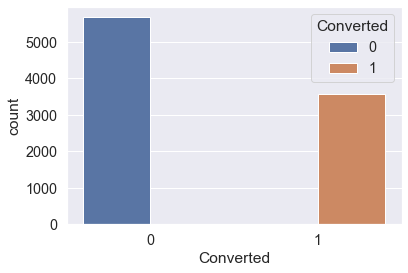

In [204]:
if IS_TEST_MODE:
    print("Converted:")
    plot_featuer(raw_df, "Converted")

Plotting Cities: <a id="cell1"></a>

Cities of leads:
Are there any NaN values:  True
Number of unique values:  7
Unique values count:
 Missing                        3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64


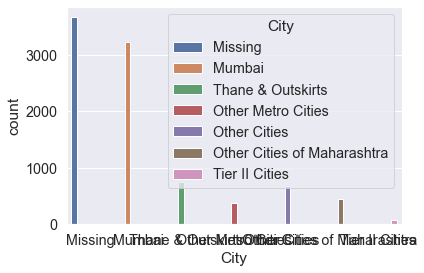

In [205]:
if IS_TEST_MODE:
    print("Cities of leads:")
    plot_featuer(raw_df, "City")

Plotting Country: <a id="cell2"></a>

Country of leads:
Are there any NaN values:  False
Number of unique values:  38
Unique values count:
 India                   8953
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Nigeria                    4
Canada                     4
Germany                    4
Kuwait                     4
South Africa               4
Sweden                     3
Belgium                    2
Philippines                2
Uganda                     2
Netherlands                2
Bangladesh                 2
Ghana                      2
Asia/Pacific Region        2
China                      2
Italy                      2
Malaysia                   1
Switzerland                1
Indonesia                  1

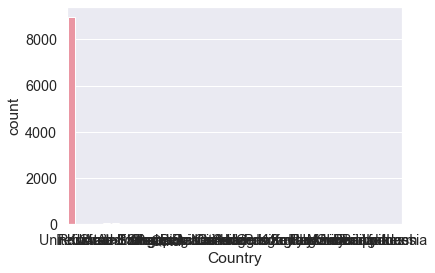

In [206]:
if IS_TEST_MODE:
    print("Country of leads:")
    plot_featuer(raw_df, "Country", False)

Plotting What is your current occupation: <a id="cell3"></a>

What is your current occupation:
Are there any NaN values:  False
Number of unique values:  6
Unique values count:
 Unemployed              8290
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64


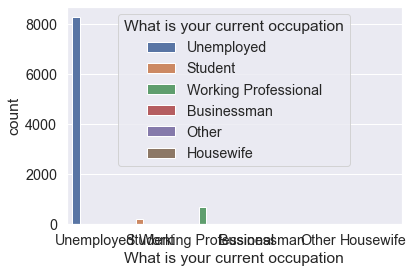

In [207]:
if IS_TEST_MODE:
    print("What is your current occupation:")
    plot_featuer(raw_df, "What is your current occupation")

Plotting Receive More Updates About Our Courses: <a id="cell4"></a>

Receive More Updates About Our Courses:
Are there any NaN values:  False
Number of unique values:  1
Unique values count:
 0    9240
Name: Receive More Updates About Our Courses, dtype: int64


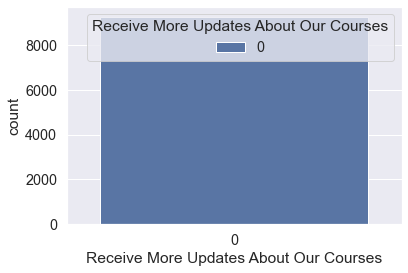

In [208]:
if IS_TEST_MODE:
    print("Receive More Updates About Our Courses:")
    plot_featuer(raw_df, "Receive More Updates About Our Courses")

Plotting Do Not Email <a id="cell5"></a>

Do Not Email:
Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    8506
1     734
Name: Do Not Email, dtype: int64


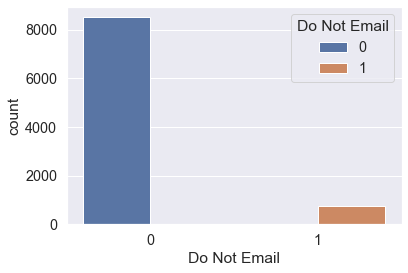

In [209]:
if IS_TEST_MODE:
    print("Do Not Email:")
    plot_featuer(raw_df, "Do Not Email")

Plotting Do Not Call <a id="cell6"></a>

Do Not Call:
Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    9238
1       2
Name: Do Not Call, dtype: int64


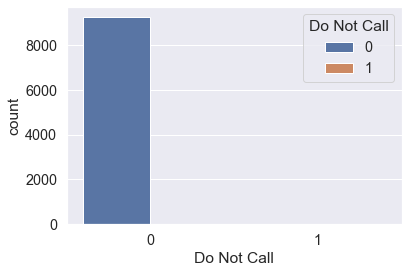

In [210]:
if IS_TEST_MODE:
    print("Do Not Call:")
    plot_featuer(raw_df, "Do Not Call")

Plotting All Features Related To "How did you hear about us": <a id="cell7"></a>

How did you hear about X Education:
Are there any NaN values:  True
Number of unique values:  10
Unique values count:
 Missing                  7250
Online Search             808
Word Of Mouth             348
Student of SomeSchool     310
Other                     186
Multiple Sources          152
Advertisements             70
Social Media               67
Email                      26
SMS                        23
Name: How did you hear about X Education, dtype: int64


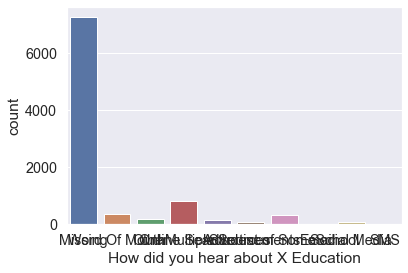

In [211]:
if IS_TEST_MODE:
    print("How did you hear about X Education:")
    plot_featuer(raw_df, "How did you hear about X Education", False)

In [212]:
if IS_TEST_MODE:
    print(raw_df[['Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations']].mean())

Search                     0.001515
Magazine                   0.000000
Newspaper Article          0.000216
X Education Forums         0.000108
Newspaper                  0.000108
Digital Advertisement      0.000433
Through Recommendations    0.000758
dtype: float64


Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    9226
1      14
Name: Search, dtype: int64


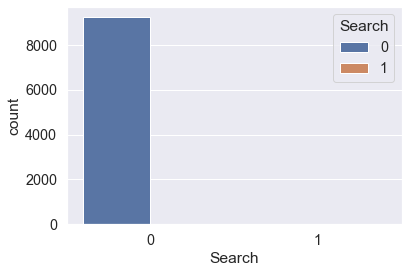

Are there any NaN values:  False
Number of unique values:  1
Unique values count:
 0    9240
Name: Magazine, dtype: int64


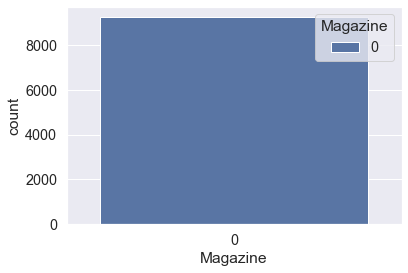

Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    9238
1       2
Name: Newspaper Article, dtype: int64


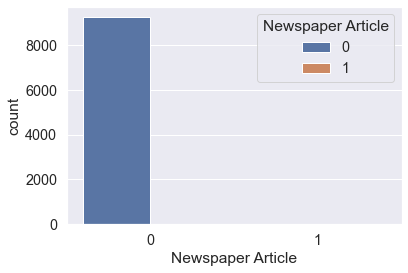

Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    9239
1       1
Name: X Education Forums, dtype: int64


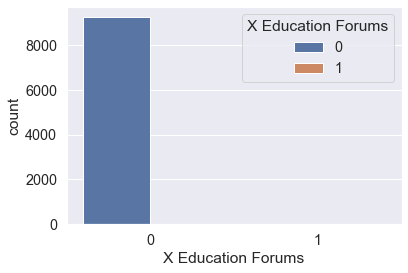

Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    9239
1       1
Name: Newspaper, dtype: int64


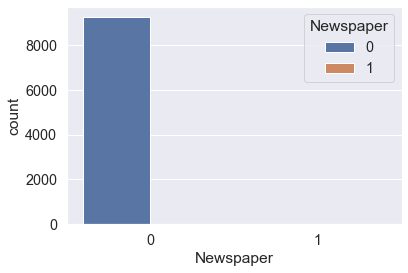

Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    9236
1       4
Name: Digital Advertisement, dtype: int64


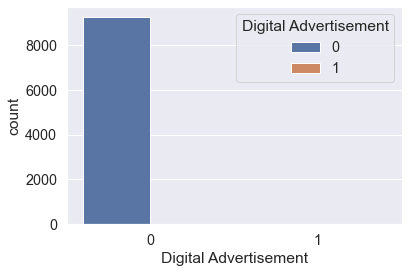

Are there any NaN values:  False
Number of unique values:  2
Unique values count:
 0    9233
1       7
Name: Through Recommendations, dtype: int64


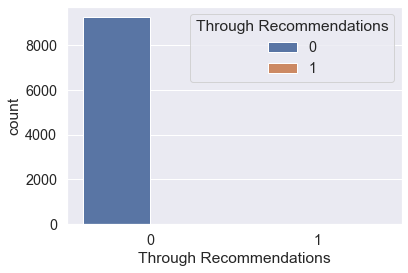

In [213]:
if IS_TEST_MODE:
    plot_multiple_feature(raw_df,['Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations'])

 Plotting All Asymmetrique Features: <a id="cell8"></a>

Are there any NaN values:  True
Number of unique values:  4
Unique values count:
 Missing    4218
2          3839
3           821
1           362
Name: Asymmetrique Activity Index, dtype: int64


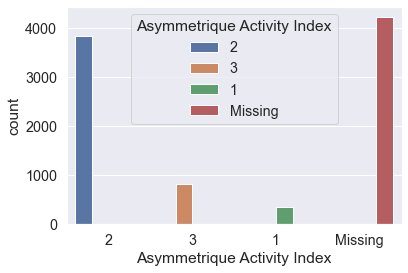

Are there any NaN values:  True
Number of unique values:  4
Unique values count:
 Missing    4218
2          2788
3          2203
1            31
Name: Asymmetrique Profile Index, dtype: int64


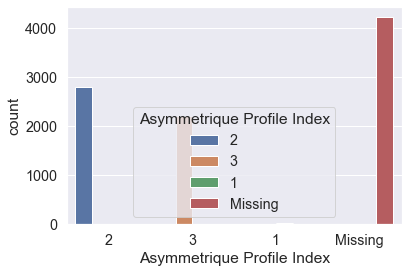

In [214]:
if IS_TEST_MODE:
    plot_multiple_feature(raw_df,['Asymmetrique Activity Index',
       'Asymmetrique Profile Index'])

Are there any NaN values:  True
Number of unique values:  13
Unique values count:
 Missing    4218
14.0       1771
15.0       1293
13.0        775
16.0        467
17.0        349
12.0        196
11.0         95
10.0         57
9.0           9
18.0          5
8.0           4
7.0           1
Name: Asymmetrique Activity Score, dtype: int64


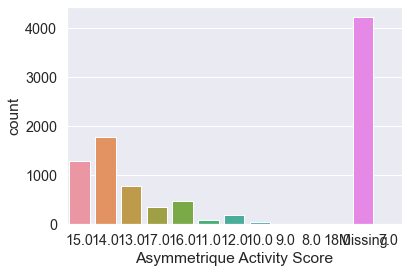

Are there any NaN values:  True
Number of unique values:  11
Unique values count:
 Missing    4218
15.0       1759
18.0       1071
16.0        599
17.0        579
20.0        308
19.0        245
14.0        226
13.0        204
12.0         22
11.0          9
Name: Asymmetrique Profile Score, dtype: int64


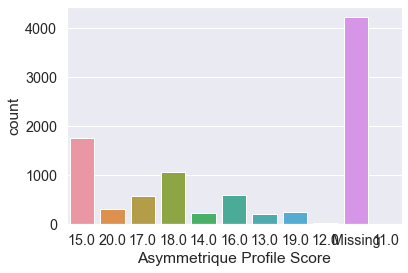

In [215]:

if IS_TEST_MODE:
    plot_multiple_feature(raw_df,['Asymmetrique Activity Score',
       'Asymmetrique Profile Score'], False)

Ploting Missing Data: <a id="general0"></a>

In [217]:
if IS_TEST_MODE:
    feature_with_missing_data(raw_df)

"Lead Source" missing data:
Number of unique values:  22
Number of Missing values:  36
Unique values count:
 Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
Missing                36
bing                    6
google                  5
Click2call              4
Live Chat               2
Press_Release           2
Social Media            2
Pay per Click Ads       1
testone                 1
youtubechannel          1
welearnblog_Home        1
blog                    1
WeLearn                 1
NC_EDM                  1
Name: Lead Source, dtype: int64
-----------------------------------------------
"TotalVisits" missing data:
Number of unique values:  42
Number of Missing values:  137
Unique values count:
 0.0        2189
2.0        1680
3.0        1306
4.0        1120
5.0         783
6.0         466
1.0         395
7.0         309
8

Splitting Countries: <a id="mf1"></a>

In [252]:
def split_countries(df):
    '''
    Will splite the Country into two - india and other (the rest of the countries will all be other).
    '''
    try:
        df.loc[df["Country"] != "India", "Country"] = "Other"
    except Exception as e:
        print(e)
    return df

Lead Source count and replace values: <a id="mf2"></a>

In [253]:
def fix_typo_in_lead_source(df):
    '''
    Fixing a typo google to match Google.
    '''
    try:
        df.loc[df["Lead Source"] == "google", "Lead Source"] = "Google"
    except Exception as e:
        print(e)
    return df

# Using the first time only to get the featuers that are above the threshold!
def replace_values_based_on_threshold_in_lead_source(df, threshold = lead_source_threshold, def_value = def_lead_source_value):
    '''
    Will make all the options in lead source the with less then the threshold sample equal to "def_value".
    This function will run only in testing to get the list of options in lead sorce.
    '''
    for source in df["Lead Source"].unique():
        if (df["Lead Source"] == source).sum() < threshold:
            df.loc[df["Lead Source"] == source, "Lead Source"] = def_value
    return df

# Use on new samples
def check_lead_source(df, ls_opt = lead_source_option, def_value = def_lead_source_value):
    '''
    If the option is not in the list of options of lead sorce featuer, they will be "def_value".
    This is set to keep the options in lead sorce always the same.
    '''
    for source in df["Lead Source"].unique():
        if source not in ls_opt: 
            df.loc[df["Lead Source"] == source, "Lead Source"] = def_value
    return df

Replacing "nan_replacment" in features: <a id="mf3"></a>

In [254]:
def map_nan_replacment_in_features(df,features = features_with_nan_map_to_other,maping = mappping_values):
    '''
    Replacing missing values in featuers to the featuer's defualt values or other.
    '''
    for feature in features:
        try:
            df.loc[df[feature] == nan_replacment, feature] = maping.get(feature,"Other")
        except Exception as e:
            print(e)
    return df

Haddling How did you hear about us featuers: <a id="mf4"></a>

In [221]:
# Create the new features
def new_featuers_with_zeros(df, features = new_featuers_lst):
    for feature in features:
        if feature not in df.columns:
            df[feature] = 0
    return df

# Merge & Drop Magazine + Newspaper Article + Newspaper
def merge_and_drop_columns(df):
    try:
        df.loc[df["Magazine"] == 1,  "Newspaper/Magazine"] = 1
        df.loc[df["Newspaper Article"] == 1,  "Newspaper/Magazine"] = 1
        df.loc[df["Newspaper"] == 1,  "Newspaper/Magazine"] = 1
        df = df.drop(["Magazine","Newspaper Article","Newspaper"],axis = 1)
    except Exception as e:
        print(e)
    return df

# Rename Digital Advertisement as Advertisement
def change_digital_advertisement_name(df):
    try:
        df.rename(columns = {"Digital Advertisement":"Advertisement"}, inplace = True)
    except Exception as e:
        print(e)
    return df

# From "How did you hear about X Education" to new features
def split_feature_to_other_features_and_drop(df, from_to_dict = mapping_featuers_to_new_featuers):
    try:
        for option,new_feature in from_to_dict.items():
            df.loc[df["How did you hear about X Education"] == option, new_feature] = 1
        df = df.drop("How did you hear about X Education", axis = 1)
    except Exception as e:
        print(e)
    return df

Drop Features: <a id="mf5"></a>

In [222]:
def drop_featuers(df, features = featuers_to_drop):
    for feature in features:
        try:
            df = df.drop(feature, axis = 1)
        except Exception as e:
            print(e)
    return df

Step 2 Data Cleaning Pipline:<a id="mf6"></a>

In [223]:
def step_2_pipline(ddf):
    df = split_countries(ddf)
    test_split_countries(df)
    
    df = fix_typo_in_lead_source(df)
    test_fix_typo_in_lead_source(df)
    
    df = check_lead_source(df)
    test_check_lead_source(df)
    
    df = map_nan_replacment_in_features(df)
    test_map_nan_replacment_in_features(df)
    
    df = new_featuers_with_zeros(df)
    test_new_featuers_with_zeros(df)
    
    df = merge_and_drop_columns(df)
    test_merge_and_drop_columns(df)
    
    df = change_digital_advertisement_name(df)
    test_hange_digital_advertisement_name(df)
    
    df = split_feature_to_other_features_and_drop(df)
    test_split_feature_to_other_features_and_drop(df)
    
    df = drop_featuers(df)
    test_drop_featuers(df)
    return df

def get_step_2_data(file_name = data_step_2):
    try: 
        df = pd.read_csv(data_file_prefix+file_name)
    except:
        df = step_2_pipline(get_step_1_data())
        df.to_csv(data_file_prefix+file_name,index=False)
    return df
        

In [224]:
def test_split_countries(df):
    county_lst = df["Country"].unique()
    if len(county_lst) == 1:
        assert "India" in county_lst or "Other" in county_lst
    else:
        assert "India" in county_lst and "Other" in county_lst
    assert df.shape[1] == 36
    
def test_fix_typo_in_lead_source(df):
    ls_lst = df["Lead Source"].unique()
    assert "google" not in ls_lst
    assert df.shape[1] == 36
    
def test_check_lead_source(df):
    for val in df["Lead Source"].unique():
        assert val in lead_source_option
    assert df.shape[1] == 36
    
def test_map_nan_replacment_in_features(df):
    assert df.shape[1] == 36
    for f in df.columns:
        assert nan_replacment not in df[f]

def test_new_featuers_with_zeros(df):
    col = df.columns
    for f in new_featuers_lst:
        assert f in col
        assert df[f].sum() == 0
    assert df.shape[1] == 41

def test_merge_and_drop_columns(df):
    assert df.shape[1] == 38
    
def test_hange_digital_advertisement_name(df):
    assert "Digital Advertisement" not in df.columns
    assert "Advertisement" in df.columns
    assert df.shape[1] == 38

def test_split_feature_to_other_features_and_drop(df):
    assert df.shape[1] == 37
    assert "How did you hear about X Education" not in df.columns
    
def test_drop_featuers(df):
    assert df.shape[1] == 29

### Models for feature engineering: <a id="mf6"></a>

OneHot Encoding: <a id="mf7"></a>

In [225]:
global onehot_models
onehot_models = {}

def ohe_path(featuer):
    return models_path_prefix+ohe_path_prefix+featuer.replace(" ", "").lower()+ohe_path_postfix

def init_onehot_models():
    df = get_step_2_data()
    for feature in one_hot_lst:
        path = ohe_path(feature)
        try:
            with open(path, 'rb') as f:
                onehot_models[feature] = pickle.load(f)
        except Exception as e:
            ohe = OneHotEncoder()
            ohe = ohe.fit(df[feature].to_numpy().reshape(-1, 1))
            onehot_models[feature] = ohe
            with open(path, 'wb') as f:
                pickle.dump(ohe, f)

def one_hot_featuers(df, features_to_ohe_lst = one_hot_lst):
    new_df = df.copy()
    for feature in features_to_ohe_lst:
        if not onehot_models.get(feature,0): init_onehot_models()
        ohe = onehot_models.get(feature,0)
        try:
            dfe = pd.DataFrame(ohe.transform(df[feature].to_numpy().reshape(-1, 1)).toarray())
            col_names = { i:f"{feature} - {col}" for i,col in enumerate(*ohe.categories_)}
            new_df = new_df.drop(feature, axis = 1)
            for key,val in col_names.items():
                new_df[val] = dfe[key]
        except Exception as e:
            print(e)
    return new_df



KNNImputer for haddling Asymmetrique Features:<a id="mf8"></a>

In [226]:
global knnimp_model
knnimp_model = {}

def init_knnimp_model():
    try:
        with open(models_path_prefix+imputer_model_path, 'rb') as f:
                knnimp_model["knn_imp"] = pickle.load(f)
    except:
        x,img_df = df_for_knnimp(one_hot_featuers(get_step_2_data()))
        knnimp_model["knn_imp"] = KNNImputer(missing_values=np.nan,n_neighbors=2)
        knnimp_model["knn_imp"].fit(x)
        with open(models_path_prefix+imputer_model_path, 'wb') as f:
            pickle.dump(knnimp_model["knn_imp"], f)

def get_or_init_knnimp(x):
    if knnimp_model.get("knn_imp",0): return knnimp_model.get("knn_imp")
    init_knnimp_model()
    return knnimp_model.get("knn_imp")

def df_for_knnimp(df):
    imp_df = df.copy()
    imp_df.loc[imp_df["Asymmetrique Activity Index"] == nan_replacment, "Asymmetrique Activity Index"] = np.nan
    imp_df.loc[imp_df["Asymmetrique Profile Index"] == nan_replacment, "Asymmetrique Profile Index"] = np.nan
    imp_df = imp_df.drop("Asymmetrique Activity Score", axis = 1).drop("Asymmetrique Profile Score", axis = 1).drop("Converted", axis = 1)
    x = imp_df[(imp_df["Asymmetrique Activity Index"] != np.nan) | (imp_df["Asymmetrique Profile Index"] != np.nan)]
    return x,imp_df

def data_imputer_on_asymmetrique_features(df):
    x,imp_df = df_for_knnimp(df)
    col_imp_df = imp_df.columns
    model = get_or_init_knnimp(x)
    imp_df = pd.DataFrame(model.transform(imp_df)).round(0)
    col_names = { i:col for i,col in enumerate(col_imp_df)}
    imp_df.rename(columns=col_names, inplace= True)
    imp_df["Asymmetrique Activity Score"]=df["Asymmetrique Activity Score"]
    imp_df["Asymmetrique Profile Score"]=df["Asymmetrique Profile Score"]
    for ac_index in imp_df["Asymmetrique Activity Index"].unique():
        imp_df.loc[(imp_df["Asymmetrique Activity Index"] == ac_index) & (imp_df["Asymmetrique Activity Score"] == nan_replacment) , "Asymmetrique Activity Score"] = asymmetrique_activity_median.get(ac_index,0)
    for ac_index in imp_df["Asymmetrique Profile Index"].unique():
        imp_df.loc[(imp_df["Asymmetrique Profile Index"] == ac_index) & (imp_df["Asymmetrique Profile Score"] == nan_replacment), "Asymmetrique Profile Score"] = asymmetrique_profile_median.get(ac_index,0)
    imp_df["Converted"]=df["Converted"]
    return imp_df

Step 3 pipline encoding featuers with models: <a id="mf9"></a>

In [227]:
def step_3_pipline(ddf):
    df = one_hot_featuers(ddf)
    test_hot_featuers(df)
    df = data_imputer_on_asymmetrique_features(df)
    return df

def get_step_3_data(file_name = data_step_3):
    try: 
        df = pd.read_csv(data_file_prefix+file_name)
    except:
        df = step_3_pipline(get_step_2_data())
        df.to_csv(data_file_prefix+file_name,index=False)
    return df   

In [228]:
def test_hot_featuers(df):
    assert df.shape[1] == 86
    test_col = one_hot_featuers(get_step_2_data()).columns
    for col in test_col:
        assert col in df.columns


### Models for predictions: 

In [229]:
global pred_models
pred_models = {}

Plotting Scores: <a id="mf10"></a>

In [230]:
def print_grid_score(grid,x_test,y_test):
    print("Best parameters set found on development set:")
    print()
    print(" %0.3f" %grid.best_score_ , grid.best_params_, "\n")
    y_true, y_pred = y_test, grid.predict(x_test)
    print(classification_report(y_true, y_pred))

Logistic regression : <a id="mf11"></a>

In [231]:
def init_lr_model():
    try:
        pred_models["lr"] = joblib.load(models_path_prefix+lr_model_path)
    except:
        df = get_step_3_data()
        x,y = df.drop("Converted", axis = 1),df["Converted"]
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=0)
        lr_grid = train_lr_model(x_train,y_train)
        pred_models["lr"] = lr_grid
        joblib.dump(pred_models["lr"], models_path_prefix+lr_model_path)
        if IS_TEST_MODE: print_grid_score(pred_models["lr"],x_test,y_test)

def train_lr_model(x_train,y_train):
    log_parm={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
    logreg=LogisticRegression(solver='liblinear')
    grid = GridSearchCV(logreg,log_parm,cv=5, scoring='roc_auc',  verbose=2, n_jobs = -1)
    grid.fit(x_train,y_train)
    return grid

def test_lr_model(x_test,y_test):
    if not pred_models.get("lr",0): init_lr_model()
    print_grid_score(pred_models["lr"],x_test,y_test)
    return pred_models["lr"].predict_proba(x_test)

def pred_prob_lr_model(df):
    if not pred_models.get("lr",0): init_lr_model()
    x,y = df.drop("Converted", axis = 1),df["Converted"]
    return pred_models["lr"].predict_proba(x)

def pred_lr_model(df):
    if not pred_models.get("lr",0): init_lr_model()
    x,y = df.drop("Converted", axis = 1),df["Converted"]
    return pred_models["lr"].predict(x)

def will_convert_prod_lr_model(df):
    prob = pred_prob_lr_model(df)
    return [int(lst[1]*100) for i,lst in enumerate(prob)]
    

In [232]:
if IS_TEST_MODE:
    n = get_step_3_data().head(1)
    print(will_convert_prod_lr_model(n))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best parameters set found on development set:

 0.920 {'C': 1.0, 'penalty': 'l1'} 

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1862
           1       0.83      0.76      0.80      1188

    accuracy                           0.85      3050
   macro avg       0.84      0.83      0.84      3050
weighted avg       0.85      0.85      0.85      3050

[12]


In [233]:
if IS_TEST_MODE:
    dfb = step_3_pipline(step_2_pipline(step_1_pipline(get_data())))
    x,y = dfb.drop("Converted", axis = 1),dfb["Converted"]
    print(pd.DataFrame({"Pred":will_convert_prod_lr_model(dfb)})["Pred"].value_counts())

99    488
4     478
2     422
1     380
3     349
     ... 
73     31
55     30
63     28
51     27
65     22
Name: Pred, Length: 100, dtype: int64


In [234]:
if IS_TEST_MODE:
    init_lr_model()
    dfc = get_step_3_data()
    x,y = dfc.drop("Converted", axis = 1),dfc["Converted"]
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=0)
    y_pred = test_lr_model(x_test,y_test)

Best parameters set found on development set:

 0.920 {'C': 1.0, 'penalty': 'l1'} 

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1862
           1       0.83      0.76      0.80      1188

    accuracy                           0.85      3050
   macro avg       0.84      0.83      0.84      3050
weighted avg       0.85      0.85      0.85      3050



In [235]:
if IS_TEST_MODE:
    n = step_1_pipline(get_data().head(1))
    print(n.shape)
    x = get_step_1_data()
    print(x.shape)
    n = step_2_pipline(n)
    print(n.shape)
    x = get_step_2_data()
    print(x.shape)

(1, 36)
(9240, 36)
(1, 29)
(9240, 29)


In [236]:
if IS_TEST_MODE:
    n = one_hot_featuers(n)
    print(n.shape)
    x = get_step_3_data()
    print(x.shape)

(1, 86)
(9240, 86)


In [237]:
if IS_TEST_MODE:
    df = step_3_pipline(step_2_pipline(step_1_pipline(get_data())))
    x = get_step_3_data()
    for col in df.columns:
        for f in df[col].unique():
            assert (x[col] == f).count() == (df[col] == f).count()
    

In [238]:
if IS_TEST_MODE:
    n = data_imputer_on_asymmetrique_features(n)
    print(n.columns)

Index(['Do Not Email', 'Do Not Call', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Search',
       'X Education Forums', 'Advertisement', 'Through Recommendations',
       'Lead Quality', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'A free copy of Mastering The Interview',
       'Other', 'Multiple Sources', 'Social Media', 'Direct Advertisement',
       'Newspaper/Magazine', 'Lead Origin - API',
       'Lead Origin - Landing Page Submission', 'Lead Origin - Lead Add Form',
       'Lead Origin - Lead Import', 'Lead Origin - Quick Add Form',
       'Lead Source - Direct Traffic', 'Lead Source - Facebook',
       'Lead Source - Google', 'Lead Source - Olark Chat',
       'Lead Source - Organic Search', 'Lead Source - Other',
       'Lead Source - Reference', 'Lead Source - Referral Sites',
       'Lead Source - Welingak Website', 'Country - India', 'Country - Other',
       'Specialization - Banking, Investment And Insurance',
    

In [239]:
if IS_TEST_MODE:
    x = step_3_pipline(step_2_pipline(step_1_pipline(get_data().head(1))))
    print(x["Asymmetrique Activity Index"].value_counts(dropna = False))
    print(x["Asymmetrique Activity Score"].value_counts(dropna = False))
    print(x["Asymmetrique Profile Index"].value_counts(dropna = False))
    print(x["Asymmetrique Profile Score"].value_counts(dropna = False))
    #     for f in x.columns:
#         print( x[f].value_counts(dropna = False))

2.0    1
Name: Asymmetrique Activity Index, dtype: int64
15.0    1
Name: Asymmetrique Activity Score, dtype: int64
2.0    1
Name: Asymmetrique Profile Index, dtype: int64
15.0    1
Name: Asymmetrique Profile Score, dtype: int64


In [240]:
if IS_TEST_MODE:
    country_df = split_countries(raw_df)
    print(country_df["Country"].value_counts(dropna = False))

India    8953
Other     287
Name: Country, dtype: int64


In [241]:
if IS_TEST_MODE:
    ls_df = replace_values_based_on_threshold_in_lead_source(fix_typo_in_lead_source(country_df))
    print("Unique values count:\n",raw_df["Lead Source"].value_counts(dropna = False))

Unique values count:
 Google              2873
Direct Traffic      2543
Olark Chat          1755
Organic Search      1154
Reference            534
Welingak Website     142
Referral Sites       125
Other                 59
Facebook              55
Name: Lead Source, dtype: int64


In [242]:
if IS_TEST_MODE:
    features = ["How did you hear about X Education", "What matters most to you in choosing a course", "Lead Profile", "City","TotalVisits","Page Views Per Visit"]
    mapping = {"Lead Profile":"Other Leads", "City":"Other Cities", "TotalVisits": int(ls_df.loc[ls_df["TotalVisits"]!= nan_replacment, "TotalVisits"].mean()), "Page Views Per Visit": int(ls_df.loc[ls_df["Page Views Per Visit"]!= nan_replacment, "Page Views Per Visit"].mean() )}
    print(mapping)
    map_df = map_nan_replacment_in_features(ls_df,features,mapping)
    for f in features:
        try:
            print("Unique values count:\n",map_df[f].value_counts(dropna = False))
            print("-----------------------------------------------")
        except:
            pass

{'Lead Profile': 'Other Leads', 'City': 'Other Cities', 'TotalVisits': 3, 'Page Views Per Visit': 2}
Unique values count:
 Other                    7436
Online Search             808
Word Of Mouth             348
Student of SomeSchool     310
Multiple Sources          152
Advertisements             70
Social Media               67
Email                      26
SMS                        23
Name: How did you hear about X Education, dtype: int64
-----------------------------------------------
Unique values count:
 Better Career Prospects      6528
Other                        2710
Flexibility & Convenience       2
Name: What matters most to you in choosing a course, dtype: int64
-----------------------------------------------
Unique values count:
 Other Leads                    7342
Potential Lead                 1613
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64
-------------------------------

In [243]:
if IS_TEST_MODE:
    newf_df = new_featuers_with_zeros(map_df, ['Other','Multiple Sources',"Social Media","Direct Advertisement","Newspaper/Magazine"])
    print(newf_df.loc[:,['Other','Multiple Sources',"Social Media","Direct Advertisement","Newspaper/Magazine"]].head(5))

   Other  Multiple Sources  Social Media  Direct Advertisement  \
0      0                 0             0                     0   
1      0                 0             0                     0   
2      0                 0             0                     0   
3      0                 0             0                     0   
4      0                 0             0                     0   

   Newspaper/Magazine  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  


In [244]:
if IS_TEST_MODE:
    merge_df = merge_and_drop_columns(newf_df)
    merge_df = change_digital_advertisement_name(merge_df)
    merge_df.columns

In [245]:
if IS_TEST_MODE:
    feature_split = {
        "Online Search": "Search",
        "Word Of Mouth" : "Through Recommendations",
        "Student of SomeSchool" : "Through Recommendations",
        "Other": "Other",
        "Multiple Sources": "Multiple Sources",
        "Advertisements" : "Advertisement",
        "Social Media" : "Social Media",
        "SMS" : "Direct Advertisement",
        "Email" : "Direct Advertisement"
    }
    split_df=split_feature_to_other_features_and_drop(merge_df,feature_split)
    print(split_df.columns)

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'X Education Forums', 'Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity',
       'Other', 'Multiple Sources', 'Social Media', 'Direct Advertisement',
       'Newspaper/Magazine'],
      dtype='object')


In [246]:
if IS_TEST_MODE:
    for feature in split_df.columns:
        unique = split_df[feature].unique()
        print(feature,": \t",nan_replacment in unique, np.nan in unique)

Lead Number : 	 False False
Lead Origin : 	 False False
Lead Source : 	 False False
Do Not Email : 	 False False
Do Not Call : 	 False False
Converted : 	 False False
TotalVisits : 	 False False
Total Time Spent on Website : 	 False False
Page Views Per Visit : 	 False False
Last Activity : 	 True False
Country : 	 False False
Specialization : 	 False False
What is your current occupation : 	 False False
What matters most to you in choosing a course : 	 False False
Search : 	 False False
X Education Forums : 	 False False
Advertisement : 	 False False
Through Recommendations : 	 False False
Receive More Updates About Our Courses : 	 False False
Tags : 	 False False
Lead Quality : 	 False False
Update me on Supply Chain Content : 	 False False
Get updates on DM Content : 	 False False
Lead Profile : 	 False False
City : 	 False False
Asymmetrique Activity Index : 	 True False
Asymmetrique Profile Index : 	 True False
Asymmetrique Activity Score : 	 True False
Asymmetrique Profile Score 

In [247]:
if IS_TEST_MODE:
    print(split_df[split_df.isnull().any(axis=1)])
    drop_df = drop_featuers(split_df, ["Receive More Updates About Our Courses",
                                    "Lead Number",
                                    "City",
                                    "Last Activity",
                                    "Tags",
                                    "Update me on Supply Chain Content",
                                    "Get updates on DM Content",
                                    "I agree to pay the amount through cheque"])
    print(drop_df.columns)

Empty DataFrame
Columns: [Lead Number, Lead Origin, Lead Source, Do Not Email, Do Not Call, Converted, TotalVisits, Total Time Spent on Website, Page Views Per Visit, Last Activity, Country, Specialization, What is your current occupation, What matters most to you in choosing a course, Search, X Education Forums, Advertisement, Through Recommendations, Receive More Updates About Our Courses, Tags, Lead Quality, Update me on Supply Chain Content, Get updates on DM Content, Lead Profile, City, Asymmetrique Activity Index, Asymmetrique Profile Index, Asymmetrique Activity Score, Asymmetrique Profile Score, I agree to pay the amount through cheque, A free copy of Mastering The Interview, Last Notable Activity, Other, Multiple Sources, Social Media, Direct Advertisement, Newspaper/Magazine]
Index: []

[0 rows x 37 columns]
Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Coun

In [248]:
if IS_TEST_MODE:
    print(drop_df.shape)
    dddf = step_2_pipline(step_1_pipline(get_data()))
    print(dddf.shape)
    df_ohe = one_hot_featuers(drop_df)
    print(df_ohe.shape)
    print(one_hot_featuers(dddf).shape)
    print(df_ohe[df_ohe.isnull().any(axis=1)])

(9240, 29)
(9240, 29)
(9240, 86)
(9240, 86)
Empty DataFrame
Columns: [Do Not Email, Do Not Call, Converted, TotalVisits, Total Time Spent on Website, Page Views Per Visit, Search, X Education Forums, Advertisement, Through Recommendations, Lead Quality, Asymmetrique Activity Index, Asymmetrique Profile Index, Asymmetrique Activity Score, Asymmetrique Profile Score, A free copy of Mastering The Interview, Other, Multiple Sources, Social Media, Direct Advertisement, Newspaper/Magazine, Lead Origin - API, Lead Origin - Landing Page Submission, Lead Origin - Lead Add Form, Lead Origin - Lead Import, Lead Origin - Quick Add Form, Lead Source - Direct Traffic, Lead Source - Facebook, Lead Source - Google, Lead Source - Olark Chat, Lead Source - Organic Search, Lead Source - Other, Lead Source - Reference, Lead Source - Referral Sites, Lead Source - Welingak Website, Country - India, Country - Other, Specialization - Banking, Investment And Insurance, Specialization - Business Administration,

In [249]:
if IS_TEST_MODE:
    imp_df = data_imputer_on_asymmetrique_features(df_ohe)
    print(imp_df["Asymmetrique Activity Index"].value_counts(dropna = False))
    print(imp_df["Asymmetrique Activity Score"].value_counts(dropna = False))
    print(imp_df["Asymmetrique Profile Index"].value_counts(dropna = False))
    print(imp_df["Asymmetrique Profile Score"].value_counts(dropna = False))
    print(imp_df.shape)

2.0    7946
3.0     903
1.0     391
Name: Asymmetrique Activity Index, dtype: int64
14.0    5878
15.0    1293
13.0     775
16.0     549
17.0     349
12.0     225
11.0      95
10.0      57
9.0        9
18.0       5
8.0        4
7.0        1
Name: Asymmetrique Activity Score, dtype: int64
2.0    5944
3.0    3265
1.0      31
Name: Asymmetrique Profile Index, dtype: int64
15.0    4915
18.0    2133
16.0     599
17.0     579
20.0     308
19.0     245
14.0     226
13.0     204
12.0      22
11.0       9
Name: Asymmetrique Profile Score, dtype: int64
(9240, 86)


In [250]:
if IS_TEST_MODE:
    for ac_index in imp_df["Asymmetrique Activity Index"].unique():
         print(ac_index," : ",df_ohe.loc[(imp_df["Asymmetrique Activity Index"] == ac_index) & (df_ohe["Asymmetrique Activity Score"] != nan_replacment)]["Asymmetrique Activity Score"].median())
    print("---------")
    for ac_index in imp_df["Asymmetrique Profile Index"].unique():
         print(ac_index," : ",df_ohe.loc[(imp_df["Asymmetrique Profile Index"] == ac_index) & (df_ohe["Asymmetrique Profile Score"] != nan_replacment)]["Asymmetrique Profile Score"].median())    

2.0  :  14.0
3.0  :  16.0
1.0  :  12.0
---------
2.0  :  15.0
3.0  :  18.0
1.0  :  12.0
